# Differential expression analysis with edgeR

from Genomic and Systems Biology at UC

In [15]:
# installation of edgeR and import
# source('http://bioconductor.org/biocLite.R')
# biocLite('edgeR',dependencies=TRUE)
library(edgeR)

Loading required package: limma
Warning message:
“package ‘limma’ was built under R version 3.3.3”

The data here was generated by the Sequencing Quality Control project

In [11]:
# read the raw data for analysis and explore the dataset
#
data_raw <- read.table("GSE49712_HTSeq.txt.gz", header = TRUE)
cat('The dimenstion of the dataframe is ', dim(data_raw), '\n')
cat('The head of the dataframe: \n')
head(data_raw)
cat('The tail of the dataframe:\n')
tail(data_raw)

The dimenstion of the dataframe is  21716 10 
The head of the dataframe: 


,A_1,A_2,A_3,A_4,A_5,B_1,B_2,B_3,B_4,B_5
1/2-SBSRNA4,74,51,36,66,34,39,41,33,35,18
A1BG,194,315,195,274,456,138,128,175,147,171
A1BG-AS1,128,129,79,145,82,115,137,100,102,45
A1CF,1360,1139,780,1552,1011,6,7,3,3,2
A2LD1,161,144,98,247,166,101,79,115,99,82
A2M,46752,42968,27571,55019,32594,13396,14316,14391,11543,7600


The tail of the dataframe:


,A_1,A_2,A_3,A_4,A_5,B_1,B_2,B_3,B_4,B_5
tAKR,0,0,0,1,0,4,3,10,3,2
no_feature,17112284,14987239,10299327,19998641,10061200,18653286,19383713,19996921,16497815,9490982
ambiguous,1429745,1318247,887845,1808331,1059290,912480,954186,956121,803816,533877
too_low_aQual,0,0,0,0,0,0,0,0,0,0
not_aligned,0,0,0,0,0,0,0,0,0,0
alignment_not_unique,8773459,7623586,5351098,10654226,6066807,8939863,9215458,9166078,7682474,4987468


In [18]:
# clean the data, get rid of the last 5 rows
#
data_clean <- data_raw[1:(nrow(data_raw)-5),]

## Quality control
1. We shouldremove genes that are unexpressed or very lowly expressed in the samples. One simple method to do this is to choose a cutoff based on the median log2-transformed counts per gene per million mapped reads (cpm)
2. A good rule of thumb when analyzing RNA-seq data from a single cell type is to expect 9-12 thousand expressed genes

The number of genes remain after cutoff: 16217

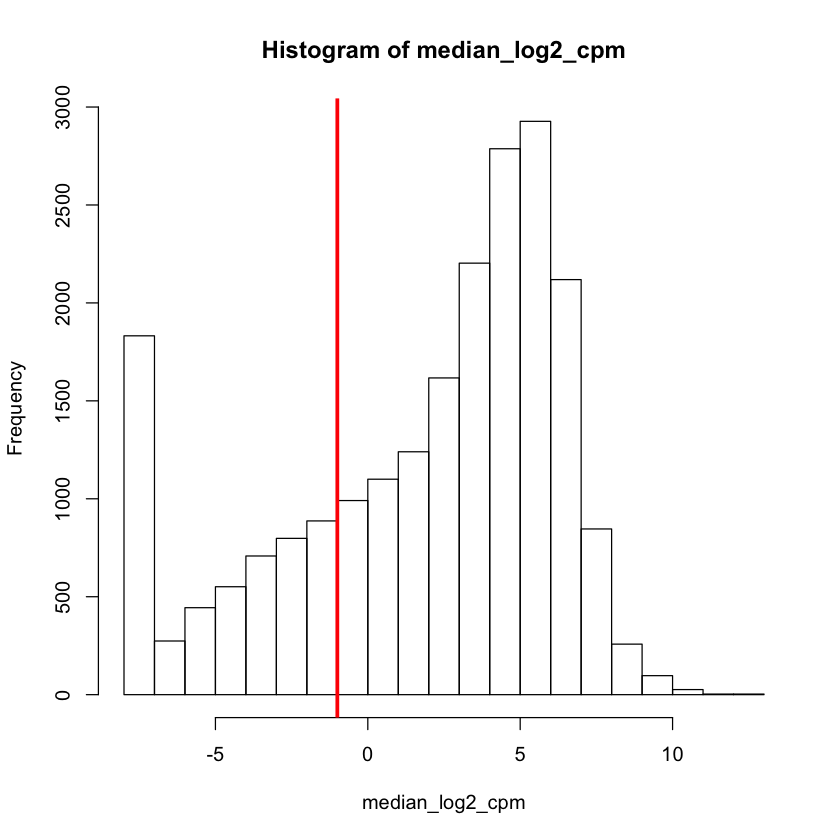

In [19]:
# remove genes are unexpressed or lowly expressed by cutoff based on cpm
#
cpm_log <- cpm(data_clean, log = TRUE)
median_log2_cpm <- apply(cpm_log, 1, median)
hist(median_log2_cpm)
expr_cutoff <- -1
abline(v = expr_cutoff, col = "red", lwd = 3)
# Normally, RNA-seq data from a single cell type is to expect 9-12 thousand expressed genes
#
cat('The number of genes remain after cutoff:', sum(median_log2_cpm > expr_cutoff))
data_clean <- data_clean[median_log2_cpm > expr_cutoff, ]

Notice that group A and B are 2 very different cell populations while the variance tech replicaets is very low

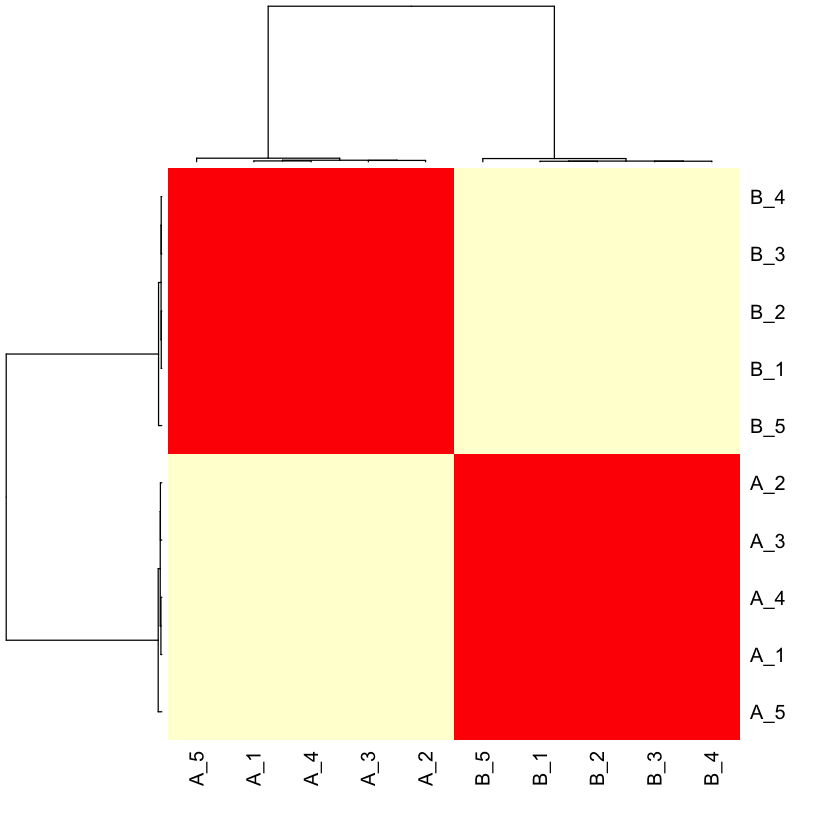

In [22]:
# quick sanity check of RNA-Seq data
#
cpm_log <- cpm(data_clean, log = TRUE)
heatmap(cor(cpm_log))
cat('Notice that group A and B are 2 very different cell populations while the variance tech replicaets is very low')

Importance of components:
                            PC1      PC2      PC3      PC4      PC5     PC6
Standard deviation     116.6955 35.20265 24.76670 14.21546 12.52034 10.9564
Proportion of Variance   0.8397  0.07642  0.03782  0.01246  0.00967  0.0074
Cumulative Proportion    0.8397  0.91614  0.95396  0.96643  0.97609  0.9835
                           PC7     PC8     PC9      PC10
Standard deviation     9.95401 9.21527 9.14721 2.759e-13
Proportion of Variance 0.00611 0.00524 0.00516 0.000e+00
Cumulative Proportion  0.98960 0.99484 1.00000 1.000e+00

Again, notice that group A and B are 2 very different cell populations while the variance tech replicaets is very low

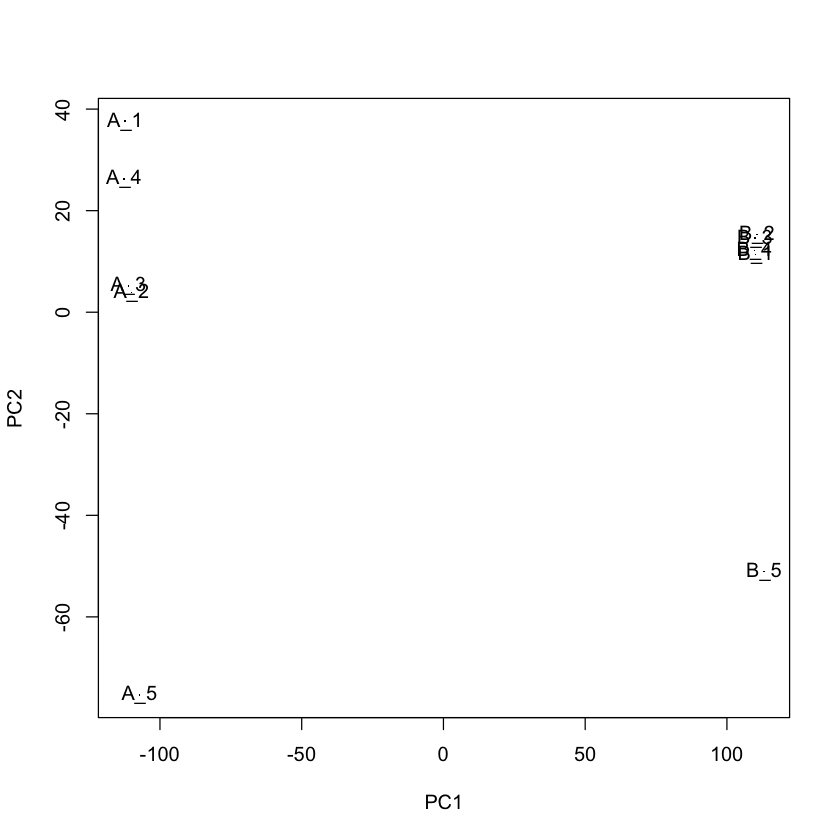

In [23]:
# sanity check by pca
#
pca <- prcomp(t(cpm_log), scale. = TRUE)
plot(pca$x[, 1], pca$x[, 2], pch = ".", xlab = "PC1", ylab = "PC2")
text(pca$x[, 1], pca$x[, 2], labels = colnames(cpm_log))
summary(pca)
cat('Again, notice that group A and B are 2 very different cell populations while the variance tech replicaets is very low')

## Two group comparison
**group**: labels each of the columns as belonging to group A or B     
**DGEList**: the object that edgeR uses for storing the data from a differential expression experiment

In [36]:
# gourp the data for DE analysis
#
group <- substr(colnames(data_clean),1,1)
group
y <- DGEList(counts=data_clean, group=group)
y

[1] "A" "A" "A" "A" "A" "B" "B" "B" "B" "B"

,A_1,A_2,A_3,A_4,A_5,B_1,B_2,B_3,B_4,B_5
1/2-SBSRNA4,74,51,36,66,34,39,41,33,35,18
A1BG,194,315,195,274,456,138,128,175,147,171
A1BG-AS1,128,129,79,145,82,115,137,100,102,45
A1CF,1360,1139,780,1552,1011,6,7,3,3,2
A2LD1,161,144,98,247,166,101,79,115,99,82
A2M,46752,42968,27571,55019,32594,13396,14316,14391,11543,7600
A2ML1,17,23,8,18,15,186,195,154,154,105
A4GALT,206,244,187,269,437,173,151,186,191,167
AAA1,86,84,56,144,82,10,9,13,13,8
AAAS,5156,5248,3458,6394,3362,2125,2349,2148,1836,979


**edgeR** normalizes the genes counts using the method TMM (trimmed means of m values) by default. Recall from lecture that the read counts for moderately to lowly expressed genes can be strongly influenced by small fluctuations in the expression level of highly expressed genes. In other words, small differences in expression of highly expressed genes between samples can give the appearance that many lower expressed genes are differentially expressed between conditions. **TMM adjusts for this by removing the extremely lowly and highly expressed genes and also those genes that are very different across samples** It then compares the total counts for this subset of genes between the two samples to get the scaling factor (this is a simplification). Similar to normalization methods for microarray data, this method assumes the majority of genes are not differentially expressed between any two samples.

In [38]:
# normailization by TMM
#
y <- calcNormFactors(y)
y$samples

,group,lib.size,norm.factors
A_1,A,63497522,1.0330870
A_2,A,58454230,1.0428743
A_3,A,39086942,1.0661454
A_4,A,78464721,1.0199137
A_5,A,48595171,1.0880712
B_1,B,62731772,0.9545962
B_2,B,65960814,0.9507299
B_3,B,66123497,0.9571425
B_4,B,55027081,0.9527139
B_5,B,37715874,0.9479338


The next step is to model **the variance of the read counts per gene**. A natural method for modeling gene counts is the Poisson distribution. However, the Poisson assumes the mean and variance are identical, but it has been found empirically that the variance in RNA-seq measurements of gene expression are larger than the mean (termed "overdispersion"). So instead the negative binomial distribution is used, which has a dispersion parameter for modeling the increase in variance from a Poisson process. edgeR treats the Poisson variance as simple sampling variance, and refers to the dispersion estimate as the "biological coefficient of variation." Though it should be mentioned that any technical biases are also included in this estimate. edgeR shares information across genes to determine a common dispersion. It extends this to a trended dispersion to model the mean-variance relationship (lowly expressed genes are typically more noisy). Lastly it calculates a dispersion estimate per gene and shrinks it towards the trended dispersion. The gene-specific (referred to in edgeR as tagwise) dispersion estimates are used in the test for differential expression.

Design matrix not provided. Switch to the classic mode.


[1] 0.1155866

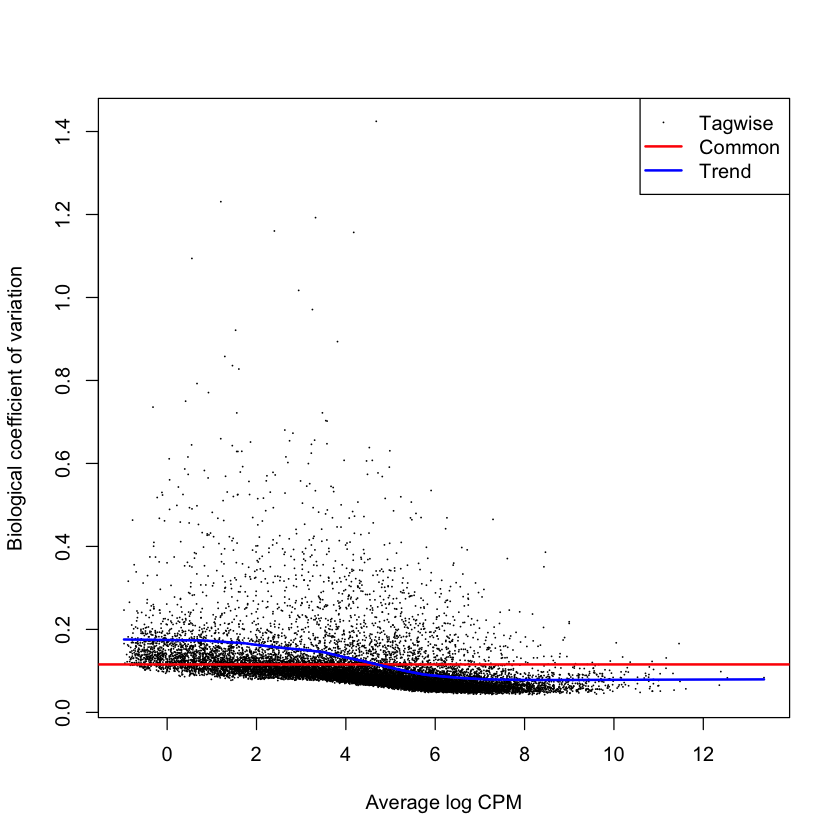

In [47]:
# The biological coefficient of variation is lower than normally seen in human studies (~0.4) 
# because the samples are technical replicates.
#
y <- estimateDisp(y)
sqrt(y$common.dispersion) # biological coefficient of variation
plotBCV(y)

## edgeR tests for differential expression
between two classes using a method similar in idea to the Fisher's Exact Test.


In [49]:
# exact test
#
et <- exactTest(y)
results_edgeR <- topTags(et, n = nrow(data_clean), sort.by = "none")
head(results_edgeR$table, 10)

,logFC,logCPM,PValue,FDR
1/2-SBSRNA4,-0.51371913,-0.3721957,7.432643e-03,8.630615e-03
A1BG,-0.76194030,1.9823193,1.325385e-02,1.519854e-02
A1BG-AS1,-0.05584884,0.9021994,7.084608e-01,7.232223e-01
A1CF,-7.94031983,3.2920524,0.000000e+00,0.000000e+00
A2LD1,-0.60005553,1.1829295,4.385280e-04,5.343458e-04
A2M,-1.60486758,8.8124892,9.779550e-197,5.576475e-196
A2ML1,3.42066564,0.6714937,3.045981e-82,9.532356e-82
A4GALT,-0.49320960,1.9925926,7.441798e-02,8.200846e-02
AAA1,-2.92357906,-0.1604373,3.677333e-42,8.188289e-42
AAAS,-1.20675016,5.8102680,7.686938e-33,1.536346e-32


## How many genes are differentially expressed at an FDR of 0.001?

Number of differentially expressed genes at an FDR of 0.001: 13433

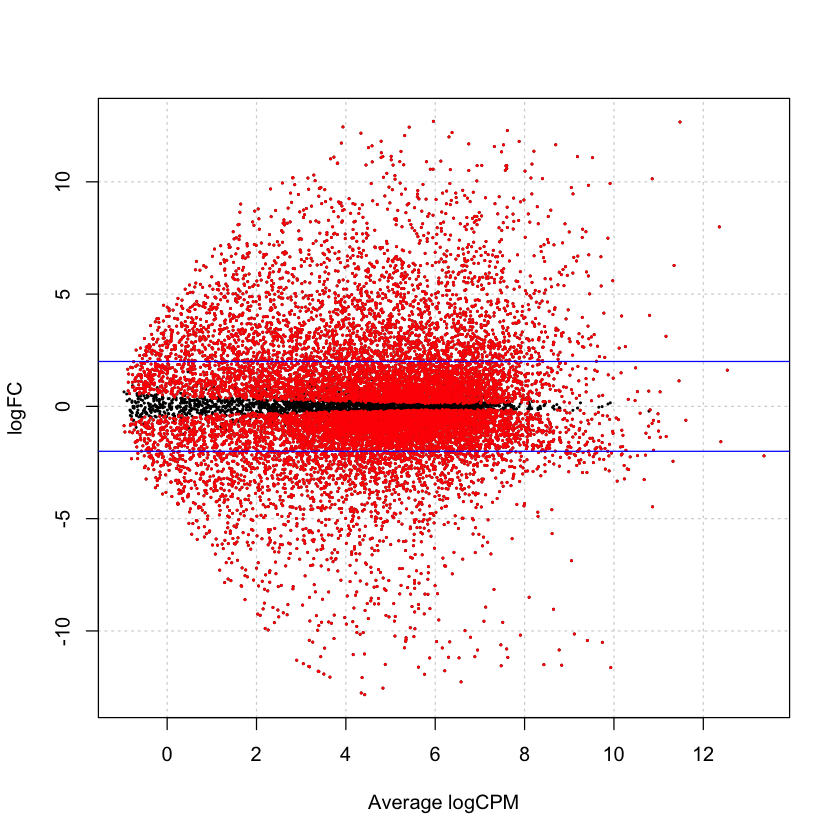

In [43]:
cat('Number of differentially expressed genes at an FDR of 0.001:', sum(results_edgeR$table$FDR < .001))
plotSmear(et, de.tags = rownames(results_edgeR)[results_edgeR$table$FDR < .01])
abline(h = c(-2, 2), col = "blue")

## Adding covariates
The previous example was a two group comparison, but if you have additional covariates, you'll need to use a generalized linear model (GLM) framework. Let's say we processed the samples in two batches and also recorded the RIN scores to control for differences in RNA quality.

In [44]:
set.seed(42)
batch <- sample(c("one", "two"), 10, replace = TRUE)
rin <- sample(6:10, 10, replace = TRUE)

In [33]:
y <- DGEList(data_clean)
y <- calcNormFactors(y)
design <- model.matrix(~group + batch + rin)
design

,(Intercept),groupB,batchtwo,rin
1,1,0,0,10
2,1,0,1,8
3,1,0,0,9
4,1,0,1,8
5,1,0,1,6
6,1,1,0,10
7,1,1,1,7
8,1,1,1,6
9,1,1,1,7
10,1,1,0,10


In [34]:
y <- estimateDisp(y, design)
fit <- glmFit(y, design)
lrt <- glmLRT(fit, coef = 2)
topTags(lrt)

,logFC,logCPM,LR,PValue,FDR
MAGEA3,-12.80034,4.421280,2857.112,0,0
MAGEA6,-12.72721,4.344390,2771.398,0,0
SPHKAP,12.67334,5.959062,5737.960,0,0
GFAP,12.66462,11.478513,7476.071,0,0
TFF1,-12.59521,4.830261,1601.996,0,0
HBB,12.47583,5.417143,4225.431,0,0
NEUROD6,12.41786,3.935673,2326.371,0,0
SYT4,12.25973,7.615150,9422.473,0,0
C1QC,12.23426,4.337224,2809.890,0,0
APOH,-12.22527,6.578153,5795.555,0,0


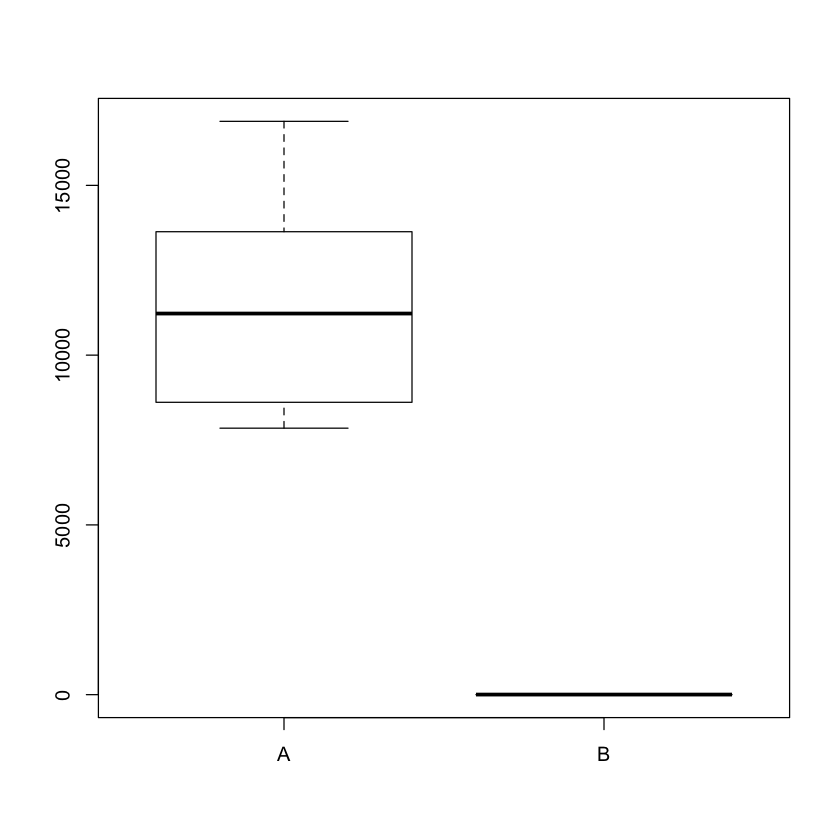

In [50]:
# a sample gene
boxplot(as.numeric(data_clean["APOH", ]) ~ group)

In [53]:
sessionInfo()

R version 3.3.2 (2016-10-31)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Sierra 10.12.4

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] edgeR_3.16.5         limma_3.30.13        BiocInstaller_1.24.0

loaded via a namespace (and not attached):
 [1] locfit_1.5-9.1  lattice_0.20-35 digest_0.6.12   crayon_1.3.2   
 [5] IRdisplay_0.4.4 grid_3.3.2      repr_0.12.0     R6_2.2.0       
 [9] jsonlite_1.4    magrittr_1.5    evaluate_0.10   stringi_1.1.5  
[13] uuid_0.1-2      IRkernel_0.7.1  splines_3.3.2   tools_3.3.2    
[17] stringr_1.2.0   pbdZMQ_0.2-5   